In [1]:
from tensorflow import keras as tfk

import numpy as np

from matplotlib import pyplot as plt

import skimage

## Load data

We can get the MNIST dataset from Keras, which is nicely partitioned into training and test data. For real-world data, you will need to load the data in by hand and manually partition it (or partition it randomly).

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = tfk.datasets.mnist.load_data()

Looking at the data, we can see that there are a large number of images, that are 28x28 (greyscale: [0,255]) pixels.

In [3]:
print('data tensor: %s ' % str(x_train_full.shape))
print('individual image size: %s' % str(x_train_full[0,:,:].shape))

print('num. training: %d; num. testing: %d' % (x_train_full.shape[0], x_test_full.shape[0]))

data tensor: (60000, 28, 28) 
individual image size: (28, 28)
num. training: 60000; num. testing: 10000


## Take a random subsample of two types of numbers from MNIST

We take $N$ samples from the 2 and 4 digits each with the idea that we want to train a binary classifier that will classify between them.

In [4]:
N = 100 # how much data of each class
c1, c2 = 2, 4 # these are our two classes for binary classification

##### Training data
This code takes a random choice of $N$ images from each class (`c1`,`c2`) and constructs a subsample as a $N\times28\times28$ tensor.

In [5]:
index_of_c1 = np.argwhere(y_train_full == c1).ravel() # index of 2s
index_of_c1 = np.random.choice(index_of_c1, N, replace=False)

index_of_c2 = np.argwhere(y_train_full == c2).ravel() # index of 4s
index_of_c2 = np.random.choice(index_of_c2, N, replace=False)

x_train = x_train_full[np.hstack((index_of_c1, index_of_c2))] # subsample
y_train = y_train_full[np.hstack((index_of_c1, index_of_c2))] # subsample

print("size of training subset: %s" % str(x_train.shape))

size of training subset: (200, 28, 28)


We'll write a short function to take a binary image and make it into an RGB by repeating 3 times along the 3rd dimension:

In [6]:
as_rgb = lambda im: np.tile(np.expand_dims(im,2),(1,1,3))

#example
print(as_rgb(x_train[0,:,:]).shape)

(28, 28, 3)


We want to resize the data, so we use the skimage `resize` utility. Essentially, for each image in `x_train`, we duplicate it to create an RGB version of the image `(28x28x3)`, and then pass to `resize`. This results in a `299x299x3` image. We combine all images into a batch tensor by stacking them along the first dimension.

In [7]:
resize = lambda im: skimage.transform.resize(as_rgb(im), (299, 299), preserve_range=False, order=0)

new_x_train = np.concatenate([[resize(x_train[i,:,:])] for i in range(x_train.shape[0])])
print(new_x_train.shape)

/home/wil/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/wil/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(200, 299, 299, 3)


##### Test Data
We now do the same but for the test data

In [8]:
index_of_c1 = np.argwhere(y_test_full == c1).ravel() # index of 2s
index_of_c1 = np.random.choice(index_of_c1, N, replace=False)

index_of_c2 = np.argwhere(y_test_full == c2).ravel() # index of 2s
index_of_c2 = np.random.choice(index_of_c2, N, replace=False)

x_test = x_test_full[np.hstack((index_of_c1, index_of_c2))]
y_test = y_test_full[np.hstack((index_of_c1, index_of_c2))]

In [9]:
new_x_test = np.concatenate([[resize(x_test[i,:,:])] for i in range(x_test.shape[0])])
print(new_x_test.shape)

(200, 299, 299, 3)


###### Some cleanup

In [10]:
del x_test_full
del x_train_full

### Plot results of resizing
You can rerun the following cell and it will get a new image from the training data and test data

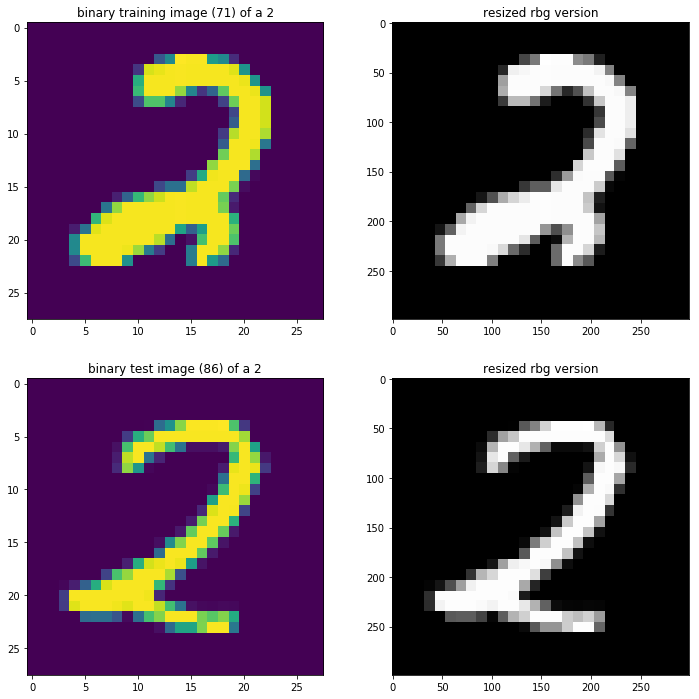

In [11]:
plt.figure(figsize=(12,12))
i = np.random.randint(0, new_x_train.shape[0])
plt.subplot(221)
plt.imshow(x_train[i,:,:])
plt.title("binary training image (%d) of a %d" % (i,y_train[i]))
plt.subplot(222)
plt.imshow(new_x_train[i,:,:])
plt.title("resized rbg version");

i = np.random.randint(0, new_x_test.shape[0])
plt.subplot(223)
plt.imshow(x_test[i,:,:])
plt.title("binary test image (%d) of a %d" % (i,y_test[i]))
plt.subplot(224)
plt.imshow(new_x_test[i,:,:])
plt.title("resized rbg version");

### Inception

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [13]:
inception = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(299,299,3)
)

W0702 18:04:13.642056 139920438748992 deprecation.py:506] From /home/wil/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Feature Extraction

We use the `inception` model to get feature vectors:

In [14]:
training_features = inception.predict(new_x_train)
print(training_features.shape)

(200, 2048)


In [15]:
test_features = inception.predict(new_x_test)
print(test_features.shape)

(200, 2048)


### Classification

We now have our feature vectors representing our 200 training images. We want to build a classifer that will characterise those. For example, we can try a linear support vector machine:

In [16]:
from sklearn.svm import LinearSVC as Classifier

In [17]:
clf = Classifier()

clf.fit(training_features, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Predict test features

In [18]:
y_predict = clf.predict(test_features)

We can compare the predicted features with the known labels and compute the accuracy

In [19]:
acc = clf.score(test_features, y_test)
print("accuracy: %f" % acc)
print("successfully classified: %d/%d" % (np.sum(y_predict == y_test), len(y_test)))

accuracy: 0.975000
successfully classified: 195/200


#### Show failed classification

Here we plot the results of incorrect classifications

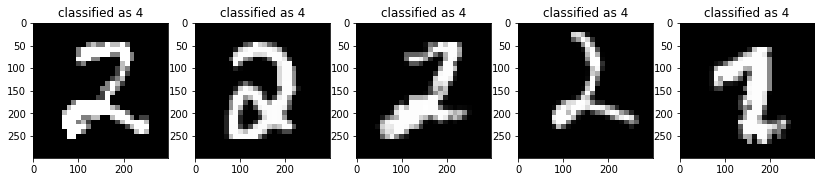

In [20]:
ix, = np.where(y_predict != y_test)

nc = min(5,len(ix))
nr = int(np.ceil(len(ix) / nc))

fig, axs = plt.subplots(nr,nc, figsize=(14,8))
axs = axs.ravel()
for k,i in enumerate(ix):
    axs[k].imshow(new_x_test[i,:,:])
    axs[k].title.set_text("classified as %d" % y_predict[i])

## Comparing classifiers

We can also do a basic comparison of different classifiers by evaluating each of them and looking at the accuracy.

For example, we look at support vector machine, linear support vector machine, linear SGD classifer, decision trees and naive Bayes:

In [21]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = {
    'svm': SVC, 
    'sgd': SGDClassifier, 
    'linearsvm': LinearSVC,
    'decisiontree': DecisionTreeClassifier,
    'naivebayes': GaussianNB
}

For each classifer, we simply fit the data and calculate the trainig and test accuracy:

In [22]:
for name, Classifer in classifiers.items():
    clf = Classifer()
    clf.fit(training_features, y_train)
    train_acc = clf.score(training_features, y_train)
    test_acc  = clf.score(test_features,  y_test)
    print("classifer: %s\n  training accuracy: %f\n  test accuracy: %f" % (name, train_acc, test_acc))

/home/wil/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classifer: svm
  training accuracy: 0.925000
  test accuracy: 0.960000
classifer: sgd
  training accuracy: 1.000000
  test accuracy: 0.955000


/home/wil/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


classifer: linearsvm
  training accuracy: 1.000000
  test accuracy: 0.975000
classifer: decisiontree
  training accuracy: 1.000000
  test accuracy: 0.905000
classifer: naivebayes
  training accuracy: 0.935000
  test accuracy: 0.945000
